In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from gp_trajectory_compensation import TrajectoryCompensatorGP

In [32]:
# --- Load observed data ---
observed_df = pd.read_csv('experiment_1.csv')
t_sec = observed_df['Time'].values  # (T,)
observed_xyz = observed_df[['x', 'y', 'z']].values  # (T, 3)
T = observed_xyz.shape[0]  # Number of time points in observed data

In [33]:
# Commanded waypoints (from G-code)
x_cmd = np.array([-96.839, -58.761, -20.692, 17.378, 55.433, 93.495, 131.553])
y_cmd = np.array([79.866, 79.841, 79.816, 79.791, 79.776, 79.751, 79.726])
z_cmd = np.array([2.91, 3.00, 3.05, 2.95, 2.85, 2.87, 2.89])

# Time vector for the 7 waypoints (you need to define this)
# For example, if the robot takes 7 seconds to move through all waypoints:
t_waypoints = np.linspace(0, 7, 7)  # Adjust start/end time as needed

# Interpolate each axis
x_interp = interp1d(t_waypoints, x_cmd, kind='linear', fill_value='extrapolate')
y_interp = interp1d(t_waypoints, y_cmd, kind='linear', fill_value='extrapolate')
z_interp = interp1d(t_waypoints, z_cmd, kind='linear', fill_value='extrapolate')

# Create commanded_xyz (254195, 3) array
commanded_xyz = np.column_stack([
    x_interp(t_sec),
    y_interp(t_sec),
    z_interp(t_sec)
])


In [34]:
# --- Create desired_xyz (T, 3) ---
x_desired = np.linspace(0, 0.3, T)  # Linear from 0 to 0.3
y_desired = np.full(T, 0.9)         # Constant at 0.9
z_desired = np.full(T, 0.8)         # Constant at 0.8
desired_xyz = np.column_stack([x_desired, y_desired, z_desired])

In [35]:
# --- Sanity check: All arrays should be (T, 3) ---
print("desired_xyz shape:", desired_xyz.shape)
print("commanded_xyz shape:", commanded_xyz.shape)
print("observed_xyz shape:", observed_xyz.shape)
print("t_sec shape:", t_sec.shape)

desired_xyz shape: (7851, 3)
commanded_xyz shape: (7851, 3)
observed_xyz shape: (7851, 3)
t_sec shape: (7851,)


In [36]:
# Downsample to 20,000 points

# step = len(t_sec) // 20000
# t_sec_ds = t_sec[::step]
# desired_xyz_ds = desired_xyz[::step]
# commanded_xyz_ds = commanded_xyz[::step]
# observed_xyz_ds = observed_xyz[::step]

In [37]:
# --- Fit the GP model ---
comp = TrajectoryCompensatorGP(include_vel=True, dt_hint=0.01, kernel='tiny', damping=1.0)
comp.fit(desired_xyz, commanded_xyz, observed_xyz, t_sec)

In [38]:
# --- Predict and compensate ---
predicted_error = comp.predict_error(commanded_xyz, desired_xyz, t_sec)
compensated_cmd = comp.compensate(desired_xyz, t_sec=t_sec, n_iter=3)


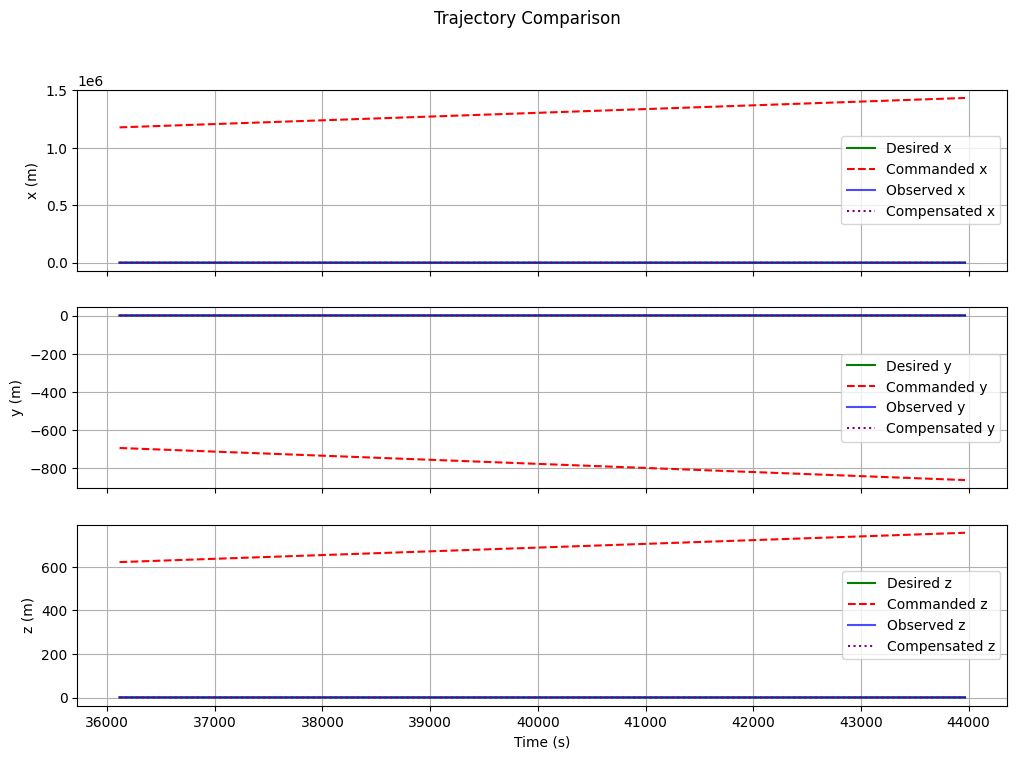

In [40]:

# Plot x, y, z trajectories
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# X-axis
axes[0].plot(t_sec, desired_xyz[:, 0], label='Desired x', color='green')
axes[0].plot(t_sec, commanded_xyz[:, 0], label='Commanded x', color='red', linestyle='--')
axes[0].plot(t_sec, observed_xyz[:, 0], label='Observed x', color='blue', alpha=0.7)
axes[0].plot(t_sec, compensated_cmd[:, 0], label='Compensated x', color='purple', linestyle=':')
axes[0].set_ylabel('x (m)')
axes[0].legend()
axes[0].grid(True)

# Y-axis
axes[1].plot(t_sec, desired_xyz[:, 1], label='Desired y', color='green')
axes[1].plot(t_sec, commanded_xyz[:, 1], label='Commanded y', color='red', linestyle='--')
axes[1].plot(t_sec, observed_xyz[:, 1], label='Observed y', color='blue', alpha=0.7)
axes[1].plot(t_sec, compensated_cmd[:, 1], label='Compensated y', color='purple', linestyle=':')
axes[1].set_ylabel('y (m)')
axes[1].legend()
axes[1].grid(True)

# Z-axis
axes[2].plot(t_sec, desired_xyz[:, 2], label='Desired z', color='green')
axes[2].plot(t_sec, commanded_xyz[:, 2], label='Commanded z', color='red', linestyle='--')
axes[2].plot(t_sec, observed_xyz[:, 2], label='Observed z', color='blue', alpha=0.7)
axes[2].plot(t_sec, compensated_cmd[:, 2], label='Compensated z', color='purple', linestyle=':')
axes[2].set_ylabel('z (m)')
axes[2].set_xlabel('Time (s)')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Trajectory Comparison')
plt.show()
